# EDA

This notebook is a short version of EDA and preprocessing for Goodreads reviews [dataset](https://www.kaggle.com/datasets/bahramjannesarr/goodreads-book-datasets-10m/data).

Note, a much larger Goodreads dataset (2017) can be found [here](https://github.com/MengtingWan/goodreads), which I did explore, preprocessed and tried to fit the on same models used in this project. 

As the purpose of this project is to benchmark results of different models, I have found this smaller dataset to be sufficient in this case.

## Imports

In [1]:
import sys
import os
dir_name = os.path.dirname(os.getcwd())
sys.path.append(dir_name)

import warnings
warnings.simplefilter("ignore")


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils.preprocess import load_user_ratings


from sklearn import preprocessing
from langdetect import detect
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Data preparation

In [2]:
# Load user user_ratings_df
# This step involves loading multiple CSV files and concatenating them into a single DataFrame.
user_ratings_df = load_user_ratings()
user_ratings_df.columns = ['user_id', 'book_name', 'rating']

print(f'Shape: {user_ratings_df.shape}')
user_ratings_df.sample(5, random_state=123)

Shape: (362596, 3)


,user_id,book_name,rating
53030,9860,All the Light We Cannot See,really liked it
350469,4493,Garcia's Heart,really liked it
350998,4544,Stolen: A Letter to My Captor,liked it
199018,1134,"Spun By Sorcery (Sugar Maple, #3)",it was amazing
70408,8104,Pride and Prejudice,it was amazing


In [3]:
user_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362596 entries, 0 to 362595
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    362596 non-null  int64 
 1   book_name  362596 non-null  object
 2   rating     362596 non-null  object
dtypes: int64(1), object(2)
memory usage: 8.3+ MB


In [4]:
user_ratings_df.nunique()

user_id        8919
book_name    103533
rating            6
dtype: int64

In [5]:
# Check for nan's
user_ratings_df.isna().any(axis=0)

user_id      False
book_name    False
rating       False
dtype: bool

In [6]:
# Change the rating from wording to numbers
le = preprocessing.OrdinalEncoder(
    categories=[
        [
            "This user doesn't have any rating",
            "did not like it",
            "it was ok",
            "liked it",
            "really liked it",
            "it was amazing",
        ]
    ]
)

user_ratings_df["rating"] = le.fit_transform(user_ratings_df["rating"].values.reshape(-1, 1))
user_ratings_df["rating"] = user_ratings_df["rating"].astype("uint8")

# Remove rows with no rating
user_ratings_df = user_ratings_df[user_ratings_df['rating']!=0]

In [7]:
# Remove book names with non english names
# Some rows cause issues while detecting the language, thus, a short function below
def is_english(title) -> bool:
    try:
        return detect(title) == 'en'
    except:
        return False
    
user_ratings_df['is_english'] = user_ratings_df['book_name'].apply(is_english)
user_ratings_df = user_ratings_df[user_ratings_df['is_english']]
user_ratings_df.drop(columns=['is_english'], inplace=True)

In [8]:
# Some popular book names need renaming - found while investigating the data
user_ratings_df.loc[user_ratings_df['book_name']== '1Q84', 'book_name'] = '1984'
user_ratings_df.loc[user_ratings_df['book_name']== "Harry Potter and the Philosopher's Stone", 'book_name'] = "Harry Potter and the Philosopher's Stone (Harry Potter, #1)"
user_ratings_df.loc[user_ratings_df['book_name']== "Harry Potter and the Sorcerer's Stone (Harry Potter, #1)", 'book_name'] = "Harry Potter and the Philosopher's Stone (Harry Potter, #1)"
user_ratings_df = user_ratings_df[~(user_ratings_df['book_name'].isin(['Harry Potter Collection (Harry Potter, #1-6)', 'Harry Potter Series Box Set (Harry Potter, #1-7)']))]

## Short Exploration

In [9]:
users_count = user_ratings_df.groupby('user_id')['rating'].count().sort_values(ascending=False).reset_index()
users_count.head(10)

,user_id,rating
0,4196,2833
1,4806,2694
2,1134,1824
3,284,1592
4,7452,1410
5,3259,1368
6,10378,1236
7,3625,1206
8,4746,1123
9,2828,1122


In [10]:
# Looks like there are some outlier users with an extortionate number of reviews made
users_count['rating'].describe()

count   3939.00
mean      65.79
std      145.69
min        1.00
25%        4.00
50%       18.00
75%       62.00
max     2833.00
Name: rating, dtype: float64

In [11]:
# Removing the users with too many user_ratings_df
x = user_ratings_df.groupby('user_id').count()['rating'] < 500
considerable_users = x[x].index
user_ratings_df = user_ratings_df[user_ratings_df['user_id'].isin(considerable_users)]

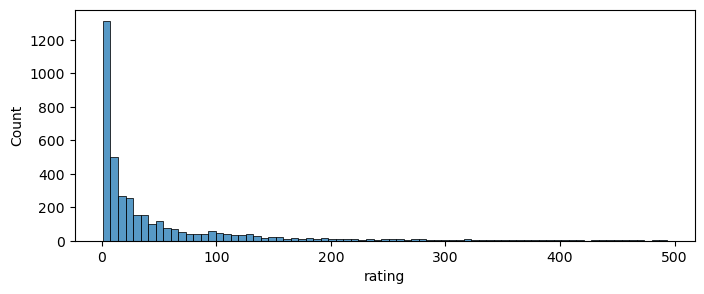

In [12]:
# Plot how many books a user reviewed
users_count = user_ratings_df.groupby('user_id')['rating'].count().sort_values(ascending=False).reset_index()
plt.figure(figsize=(8, 3))
fig = sns.histplot(users_count['rating'])
plt.show()

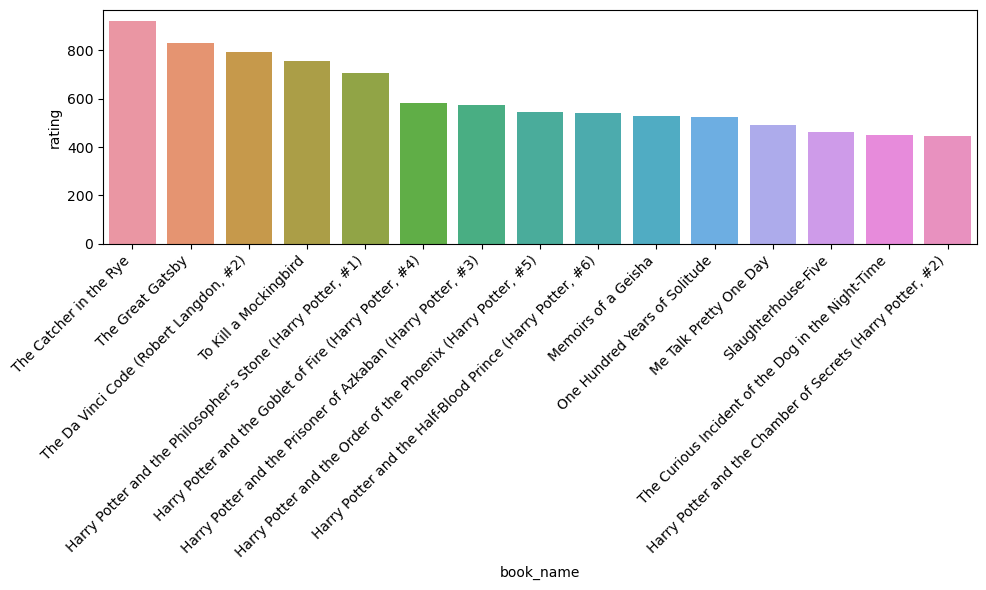

In [13]:
# Plot the most reviewed books.
books_count = user_ratings_df.groupby('book_name')['rating'].count().sort_values(ascending=False).reset_index()
plt.figure(figsize=(10,6))
fig = sns.barplot(x=books_count.head(15)['book_name'], y=books_count.head(50)['rating'])
fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.tight_layout()
plt.show()
     

Text(0.5, 1.0, 'Books rating distribution')

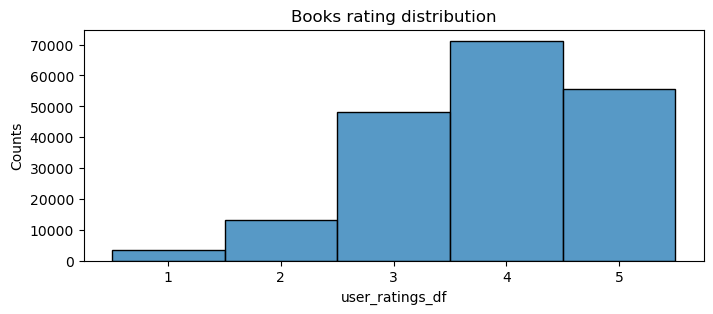

In [14]:
# user_ratings_df distribution
_, ax = plt.subplots(figsize=(8, 3))
sns.histplot(user_ratings_df['rating'], ax=ax, discrete=True)
ax.set_ylabel('Counts')
ax.set_xlabel('user_ratings_df')
ax.set_title('Books rating distribution')

In [15]:
# Group data to get statistics
for parameter in ['book_name', 'user_id']:
    user_ratings_df_by_param = user_ratings_df[[parameter, 'rating']] \
        .groupby(parameter, observed=True).count()
    rated_count = len(user_ratings_df_by_param)
    five_times_rated_count = (user_ratings_df_by_param['rating'] >= 20).sum()
    ten_times_rated_count = (user_ratings_df_by_param['rating'] > 50).sum()
    print(f'Number of {parameter} which have user_ratings_df: {rated_count}')
    print(f'Number of {parameter} which have at least 20 user_ratings_df: '
          f'{five_times_rated_count}')
    print(f'Number of {parameter} which more than 50 user_ratings_df: '
          f'{ten_times_rated_count}\n')
print(f'Total number of user_ratings_df: {len(user_ratings_df)}')

Number of book_name which have user_ratings_df: 54072
Number of book_name which have at least 20 user_ratings_df: 1318
Number of book_name which more than 50 user_ratings_df: 472

Number of user_id which have user_ratings_df: 3853
Number of user_id which have at least 20 user_ratings_df: 1816
Number of user_id which more than 50 user_ratings_df: 1052

Total number of user_ratings_df: 191428


## Benchmarking processing

The most popular dataset for recommender benchmarking is [movielens 100k](https://grouplens.org/datasets/movielens/100k/) (1998).

The data is of 100k size, has 943 unique users and 1683 movies. All users have at least 20 reviews and there are 1000 movies with at least 15 user_ratings_df.

Thus, I've also decided to separate users with fewer than 20 user_ratings_df to simplify the problem (the "cold-start" issue) - a different modelling approach could be applied for these particular users. Further, as the data isn't perfect I only keep books with a higher than 10 number of reviews.

This leaves us with data size of 91k, 1.3k users and 2.7k books.



In [16]:
y = user_ratings_df.groupby('book_name').count()['rating'] >= 10
famous_books = y[y].index
user_ratings_df_filt = user_ratings_df[user_ratings_df['book_name'].isin(famous_books)]

x = user_ratings_df_filt.groupby('user_id').count()['rating'] > 20
considerable_users = x[x].index
user_ratings_df_filt = user_ratings_df_filt[user_ratings_df_filt['user_id'].isin(considerable_users)]

user_ratings_df_filt.reset_index(inplace=True, drop=True)
print(f'Number of Reviews: {len(user_ratings_df_filt)}')
print(f'Number of Users: {user_ratings_df_filt.user_id.nunique()}')
print(f'Number of Books: {user_ratings_df_filt.book_name.nunique()}')
user_ratings_df_filt.head()


Number of Reviews: 91016
Number of Users: 1372
Number of Books: 2711


,user_id,book_name,rating
0,1,The Restaurant at the End of the Universe (Hit...,5
1,1,"Ready Player One (Ready Player One, #1)",4
2,1,The Name of the Rose,3
3,1,Bad Blood: Secrets and Lies in a Silicon Valle...,4
4,1,A Short History of Nearly Everything,5


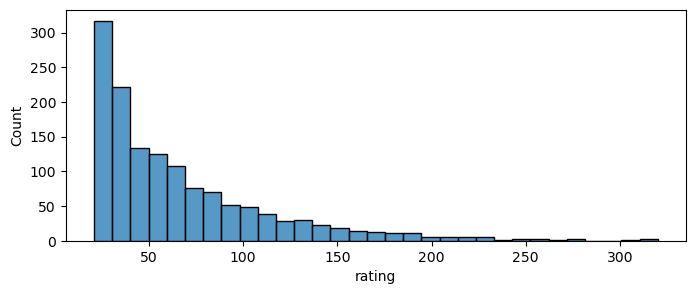

In [17]:
users_count = user_ratings_df_filt.groupby('user_id')['rating'].count().sort_values(ascending=False).reset_index()
plt.figure(figsize=(8, 3))
fig = sns.histplot(users_count['rating'])
plt.show()

In [18]:
users_count['rating'].describe()

count   1372.00
mean      66.34
std       47.86
min       21.00
25%       32.00
50%       51.00
75%       86.00
max      320.00
Name: rating, dtype: float64

In [19]:
# Save the data
user_ratings_df_filt.to_csv(os.path.join(dir_name, 'src', 'data', 'goodreads_2m', 'ratings.csv'), index=False)